In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
import joblib
import re
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import nltk

Предварительное изучение данных

In [2]:
# Смотрим на данные
train_data = pd.read_parquet('hackaton_train_types_recom.parquet')
train_data.head(10)

,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column
6762112,https://cdn1.ozone.ru/s3/multimedia-d/65647598...,Фильтр АКПП HYUNDAI GETZ 02-10/ELANTRA 1.8 00-...,Ремкомплект двигателя мототехники,None,None,False,0,nan_False_0
2248350,https://cdn1.ozone.ru/s3/multimedia-r/67002690...,"Масло оливковое Urzante Light рафинированное, ...",Растительное масло,None,None,False,1,nan_False_1
2940012,https://cdn1.ozone.ru/multimedia/1026904772.jpg,Свитшот Reebok Cl A Crew,Оповещатель,None,None,False,0,nan_False_0
7671340,https://cdn1.ozone.ru/s3/multimedia-1-r/700080...,Клин съемник для снятия пластика в авто,Съемник,None,None,False,1,nan_False_1
795605,https://cdn1.ozone.ru/s3/multimedia-1-u/712028...,HXD Пыльник,Олимпийка,None,None,False,0,nan_False_0
230835,https://cdn1.ozone.ru/s3/multimedia-1-d/719643...,Кроссовки Air Jordan JT 2 Баскетбольная обувь ...,Моноласта,Обувь,Кроссовки,True,0,Обувь_True_0
934908,https://cdn1.ozone.ru/s3/multimedia-1-o/725771...,Подарочный праздничный пакет на День рождения ...,Пакет подарочный,None,None,True,1,nan_True_1
150710,https://cdn1.ozone.ru/s3/multimedia-1-r/711064...,Подвесной держатель для медалей,Стеллаж для игрушек,Дом и сад,Ящик для игрушек,True,0,Дом и сад_True_0
559188,https://cdn1.ozone.ru/s3/multimedia-y/65861909...,Свидетельство о венчании в твердом переплете с...,Сменный блок для когтеточек,None,None,False,0,nan_False_0
6055908,https://cdn1.ozone.ru/s3/multimedia-j/68085042...,"Силиконовая скатерть прозрачная на стол, клеен...",Трость-стул,None,None,False,0,nan_False_0


In [3]:
# Смотрим на данные
test_data = pd.read_parquet('hackaton_test_types_recom.parquet')
test_data.head(10)

,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column
7809846,https://cdn1.ozone.ru/s3/multimedia-t/63327116...,"Защитный кейс (бокс, чехол) для карт памяти SD...",Комплект фотоаксессуаров,None,None,False,1,nan_False_1
97704,https://cdn1.ozone.ru/s3/multimedia-1-h/714445...,Кружка латте керамическая большая для чая и ко...,Кружка,Дом и сад,Кружка,False,1,Дом и сад_False_1
446046,https://cdn1.ozone.ru/s3/multimedia-1-q/719594...,"Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ...",Удлинитель сантехнический,Строительство и ремонт,Фитинг сантехнический,True,1,Строительство и ремонт_True_1
511281,https://cdn1.ozone.ru/s3/multimedia-1-w/722827...,"Интерьерная картина ""Кирпичи в руинах древней ...",Картина,Дом и сад,Картина,False,1,Дом и сад_False_1
50527,https://cdn1.ozone.ru/s3/multimedia-1-3/696992...,"Ножницы Волна , 9"", 23 см, шаг - 18 мм, цвет ч...",Пирог,Хобби и творчество,Набор для шитья одежды,True,0,Хобби и творчество_True_0
843680,https://cdn1.ozone.ru/s3/multimedia-1-i/702841...,Аксельбант офицерский желтый,Станок для натягивания проволоки в рамке для пчел,None,None,False,0,nan_False_0
558059,https://cdn1.ozone.ru/s3/multimedia-w/65340423...,"15 шт. Мелки школьные Гамма, цветные, 10шт., м...",Проживание в пансионате,Канцелярские товары,Мелки,True,0,Канцелярские товары_True_0
52215,https://cdn1.ozone.ru/s3/multimedia-1-z/708798...,Бра LED,Подсветка для картин,Строительство и ремонт,Настенный светильник,True,1,Строительство и ремонт_True_1
7237878,https://cdn1.ozone.ru/s3/multimedia-1-f/714310...,"Таблетированная соль Rockmelt 4-в-1, 20 кг.",Украшение настольное интерьерное,None,None,False,0,nan_False_0
225586,https://cdn1.ozone.ru/s3/multimedia-1-p/704666...,Набор сверл-метчиков по металлу из быстрорежущ...,Сверло,None,None,False,1,nan_False_1


In [4]:
# Объединяем данные в один файл
data = pd.concat([train_data, test_data])
data.head()

,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column
6762112,https://cdn1.ozone.ru/s3/multimedia-d/65647598...,Фильтр АКПП HYUNDAI GETZ 02-10/ELANTRA 1.8 00-...,Ремкомплект двигателя мототехники,None,None,False,0,nan_False_0
2248350,https://cdn1.ozone.ru/s3/multimedia-r/67002690...,"Масло оливковое Urzante Light рафинированное, ...",Растительное масло,None,None,False,1,nan_False_1
2940012,https://cdn1.ozone.ru/multimedia/1026904772.jpg,Свитшот Reebok Cl A Crew,Оповещатель,None,None,False,0,nan_False_0
7671340,https://cdn1.ozone.ru/s3/multimedia-1-r/700080...,Клин съемник для снятия пластика в авто,Съемник,None,None,False,1,nan_False_1
795605,https://cdn1.ozone.ru/s3/multimedia-1-u/712028...,HXD Пыльник,Олимпийка,None,None,False,0,nan_False_0


In [8]:
# Изучаем данные
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 953767 entries, 6762112 to 6192728
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   main_photo       953767 non-null  object
 1   name             953767 non-null  object
 2   type             953767 non-null  object
 3   category_l2      553010 non-null  object
 4   category_l4      553010 non-null  object
 5   is_markup        953767 non-null  bool  
 6   target           953767 non-null  int64 
 7   stratify_column  953767 non-null  object
dtypes: bool(1), int64(1), object(6)
memory usage: 59.1+ MB


In [9]:
# Смотрим размерность
data.shape

(953767, 8)

In [10]:
# Считаем пропуски
missing_count = data.isna().sum()
print(missing_count)

main_photo              0
name                    0
type                    0
category_l2        400757
category_l4        400757
is_markup               0
target                  0
stratify_column         0
dtype: int64


main_photo — ссылка на главное изображение товара.
name — название товара.
type — тип товара (например, комплект, кружка и т.д.).
category_l2 — вторая категория товара, классифицирующая его по более узкому признаку.
category_l4 — четвёртая категория товара, дающая ещё более детальную классификацию, если применимо.
is_markup — указывает, есть ли на товар наценка (TRUE или FALSE).
target — может указывать на какие-то метки или целевые группы (например, 1 или 0).
stratify_column — колонка для стратификации, возможно, для группировки данных.
__index_level_0 — индексная колонка, вероятно, идентификатор строки или номер записи в таблице.

Подготовка данных

In [5]:
# Удаляем ненужные колонки
columns_to_drop = data[['main_photo', 'is_markup', 'target', 'stratify_column']]
data = data.drop(columns=columns_to_drop, axis=1)
data.head()

,name,type,category_l2,category_l4
6762112,Фильтр АКПП HYUNDAI GETZ 02-10/ELANTRA 1.8 00-...,Ремкомплект двигателя мототехники,None,None
2248350,"Масло оливковое Urzante Light рафинированное, ...",Растительное масло,None,None
2940012,Свитшот Reebok Cl A Crew,Оповещатель,None,None
7671340,Клин съемник для снятия пластика в авто,Съемник,None,None
795605,HXD Пыльник,Олимпийка,None,None


In [13]:
# Смотрим на столбец category_l2
data['category_l2'].value_counts()

category_l2
Дом и сад                           106510
Строительство и ремонт               71002
Автотовары                           69001
Одежда                               48705
Электроника                          44444
Галантерея и аксессуары              23181
Мебель                               22421
Обувь                                22195
Детские товары                       21650
Красота и гигиена                    19935
Спорт и отдых                        19181
Хобби и творчество                   18872
Товары для животных                  11166
Бытовая техника                      10599
Канцелярские товары                  10075
Аптека                                8124
Книги                                 6608
Товары для взрослых                   5921
Продукты питания                      3488
Продукты питания Ozon Fresh           1911
Антиквариат и коллекционирование      1834
Бытовая химия                         1499
Музыкальные инструменты               1361

In [14]:
# Смотрим на столбец category_l4
data['category_l4'].value_counts()

category_l4
Картина                              30354
Фотообои                             22039
Матрас                               14917
Светильник для дома                  14084
Автофильтры                          13668
                                     ...  
Манок                                    1
Овоскоп                                  1
Молочная смесь для детей до 3 лет        1
Песок для купания                        1
Тетрадь нотная                           1
Name: count, Length: 3397, dtype: int64

In [15]:
# Заменяем \N на unknown
data["category_l2"] = data["category_l2"].replace("\\N", "unknown")
data["category_l4"] = data["category_l4"].replace("\\N", "unknown")

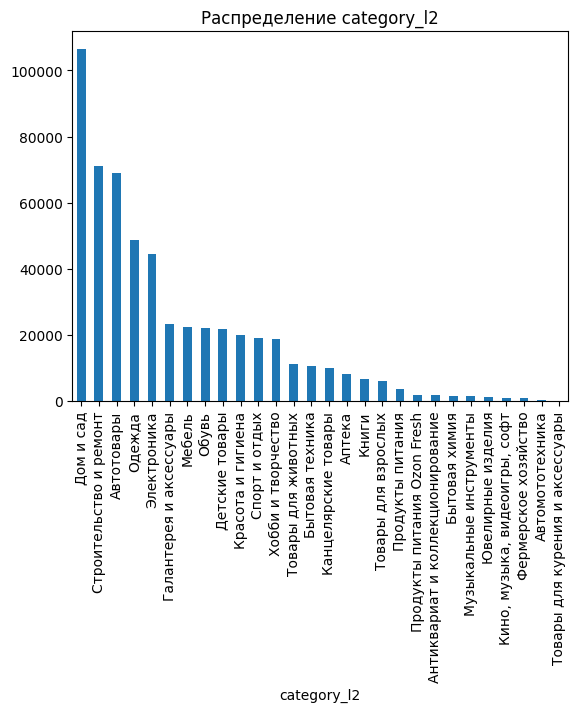

In [16]:
# Смотрим распределение category_l2
data["category_l2"].value_counts().plot(kind="bar")
plt.title("Распределение category_l2")
plt.show()

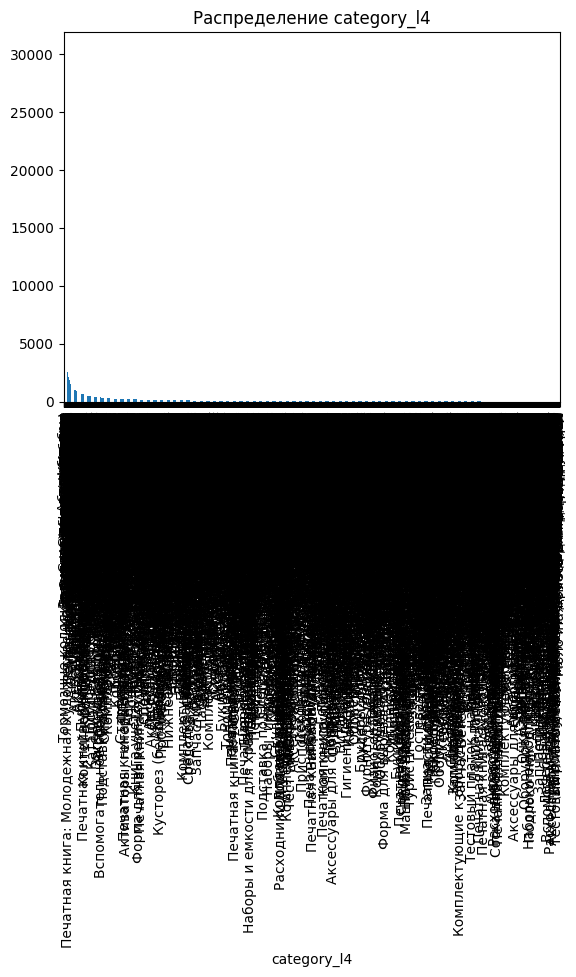

In [17]:
# Смотрим распределение category_l4
data["category_l4"].value_counts().plot(kind="bar")
plt.title("Распределение category_l4")
plt.show()

In [6]:
# Удаляем столбцы, т.к. в них много незаполненных значений
data.drop(["category_l2", "category_l4"], axis=1, inplace=True)

In [7]:
data.head()

,name,type
6762112,Фильтр АКПП HYUNDAI GETZ 02-10/ELANTRA 1.8 00-...,Ремкомплект двигателя мототехники
2248350,"Масло оливковое Urzante Light рафинированное, ...",Растительное масло
2940012,Свитшот Reebok Cl A Crew,Оповещатель
7671340,Клин съемник для снятия пластика в авто,Съемник
795605,HXD Пыльник,Олимпийка


In [7]:
# Функция очистки текста
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

tqdm.pandas()  # Активируем progress_apply
# Применяем функцию
data['clean_type'] = data['type'].progress_apply(clean_text)  # с прогресс-баром
print(data[['type', 'clean_type']].head())  # сравнение оригинала и очищенного текста
print("Размер DataFrame:", data.shape)

100%|██████████| 953767/953767 [00:02<00:00, 398426.92it/s]

                                      type                         clean_type
6762112  Ремкомплект двигателя мототехники  ремкомплект двигателя мототехники
2248350                 Растительное масло                 растительное масло
2940012                        Оповещатель                        оповещатель
7671340                            Съемник                            съемник
795605                           Олимпийка                          олимпийка
Размер DataFrame: (953767, 3)


In [8]:
# Лемматизация

# Инициализируем инструменты
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag: str) -> str:
    """Конвертирует POS-теги NLTK в формат WordNet."""
    return {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }.get(treebank_tag[0], wordnet.NOUN)  # По умолчанию: существительное

def lemmatize_text(text: str) -> str:
    if not text.strip(): 
        return ""
    
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    
    lemmas = []
    for token, tag in pos_tags:
        wordnet_pos = get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(token, pos=wordnet_pos)
        lemmas.append(lemma)
    
    return " ".join(lemmas)

tqdm.pandas()  # Активируем progress_apply
# Добавляем колонки с лемматизацией
data['lemmatized_type'] = data['clean_type'].progress_apply(lemmatize_text)

# Проверка результата
print(data[['clean_type', 'lemmatized_type']].head(3))

100%|██████████| 953767/953767 [01:35<00:00, 10023.29it/s]

                                clean_type                    lemmatized_type
6762112  ремкомплект двигателя мототехники  ремкомплект двигателя мототехники
2248350                 растительное масло                 растительное масло
2940012                        оповещатель                        оповещатель


In [11]:
data.columns

Index(['name', 'type', 'clean_type', 'lemmatized_type'], dtype='object')

Эксперимент с алгоритмом K-means (кластеризация)

In [9]:
# Создание объекта tf.data.Dataset
# Замена NaN значений на пустую строку
data['lemmatized_type'] = data['lemmatized_type'].fillna('')
# Выбираем частичную выборку данных (например, 20% от всех данных)
#sample_size = int(len(data) * 0.2)  # 20% данных
#sampled_data = data.sample(n=sample_size, random_state=42)
dataset = tf.data.Dataset.from_tensor_slices(data['lemmatized_type'].astype(str).values)

In [10]:
# Векторизация с использованием TensorFlow
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=10000)
vectorize_layer.adapt(dataset.batch(1024))

In [11]:
# Применяем векторизацию
tfidf_matrix = vectorize_layer(data['lemmatized_type'].values)
print('Размер TF-IDF матрицы:', tfidf_matrix.shape)

Размер TF-IDF матрицы: (953767, 10)


In [12]:
from scipy import sparse  # Измените импорт здесь

tfidf_sparse_matrix = sparse.csr_matrix(tfidf_matrix.numpy())  # Используйте sparse здесь

# Сохраняем разреженную матрицу
sparse.save_npz('tfidf_matrix.npz', tfidf_sparse_matrix)

In [13]:
# Кластеризация KMeans
num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters, random_state=42)


kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(tfidf_matrix.numpy())  # Преобразуем тензор в NumPy массив

predictions = kmeans.labels_

# Получаем названия всех слов
vocabulary = vectorize_layer.get_vocabulary()  # Получаем словарь
vocabulary_size = len(vocabulary)

# Создаём словарь для хранения типичных слов для каждого кластера
clustered_words = {}

# Заполняем словарь
for cluster in range(num_clusters):
    # Получаем индексы слов, относящихся к данному кластеру
    top_indices = kmeans.cluster_centers_[cluster].argsort()[-1:][::-1]  # 25 самых важных слов
    top_words = [vocabulary[i] for i in top_indices if i < vocabulary_size]  # Проверка на размер словаря
    clustered_words[cluster] = top_words

# Теперь можно создать список из clustered_words
cluster_word_list = [f"{cluster} - {', '.join(words)}" for cluster, words in clustered_words.items()]

# Выводим список
for entry in cluster_word_list:
    print(entry)

0 - [UNK]
1 - для
2 - 
3 - [UNK]
4 - 
5 - 
6 - для
7 - 
8 - картина
9 - для
10 - [UNK]
11 - для
12 - 
13 - картина
14 - 
15 - 
16 - для
17 - для
18 - картина
19 - [UNK]
20 - 
21 - картина
22 - фотообои
23 - 
24 - набор
25 - для
26 - [UNK]
27 - 
28 - картина
29 - для
30 - [UNK]
31 - [UNK]
32 - для
33 - для
34 - для
35 - [UNK]
36 - 
37 - 
38 - для
39 - фотообои
40 - [UNK]
41 - картина
42 - 
43 - 
44 - для
45 - набор
46 - 
47 - 
48 - [UNK]
49 - картина
50 - 
51 - картина
52 - [UNK]
53 - [UNK]
54 - 
55 - [UNK]
56 - картина
57 - 
58 - 
59 - картина
60 - набор
61 - картина
62 - для
63 - [UNK]
64 - 
65 - 
66 - 
67 - 
68 - для
69 - картина
70 - фотообои
71 - набор
72 - 
73 - комплект
74 - для
75 - [UNK]
76 - [UNK]
77 - для
78 - картина
79 - для
80 - фотообои
81 - [UNK]
82 - 
83 - для
84 - [UNK]
85 - картина
86 - картина
87 - 
88 - 
89 - набор
90 - картина
91 - [UNK]
92 - набор
93 - для
94 - для
95 - 
96 - [UNK]
97 - [UNK]
98 - 
99 - для


In [ ]:
#Сохраняем предсказания в отдельную колонку
data['kmeans_30'] = predictions

In [ ]:
#Сохраняем модель в файл
joblib.dump(kmeans, 'kmeans_30.pkl')

['kmeans_30.pkl']

Эксперимент с алгоритмом k ближайших соседей (классификация)

In [19]:
from sklearn.preprocessing import StandardScaler
# Разделение данных на тренировочную и тестовую выборки
#sample_size = 10000  # Укажите желаемое количество строк
#data_sample = data.sample(n=sample_size, random_state=42)

# Разделение данных на тренировочную и тестовую выборки
X = data['lemmatized_type']
y = data['kmeans_30']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Векторизация текста для KNN
X_train_final = vectorize_layer(X_train.values).numpy()
X_test_final = vectorize_layer(X_test.values).numpy()

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)


# Задаем разные значения для K и оцениваем эффективность
best_f1 = 0
best_k = 1

for k in range(1, 21):  # Например, пробуем от 1 до 20 соседей
    knn = KNeighborsClassifier(n_neighbors=k)
    y_train_pred = cross_val_predict(knn, X_train_scaled, y_train, cv=5, n_jobs=-1)
    
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    
    if f1_train > best_f1:
        best_f1 = f1_train
        best_k = k

# Обучаем финальную модель с наилучшим k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# Предсказания на тестовой выборке
y_test_pred = knn.predict(X_test_scaled)

# Расчет метрик на тренировочной выборке
print(f"Best K: {best_k}")
print(f"Train F1 Score (Best K): {best_f1}")

# Расчет метрик на тестовой выборке
f1_test = f1_score(y_test, y_test_pred, average='weighted')
accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, average='weighted')
precision_test = precision_score(y_test, y_test_pred, average='weighted')

print(f"Test F1 Score: {f1_test}")
print(f"Test Accuracy: {accuracy_test}")
print(f"Test Recall: {recall_test}")
print(f"Test Precision: {precision_test}")

Best K: 1
Train F1 Score (Best K): 0.9999069484576151
Test F1 Score: 0.9999056389650306
Test Accuracy: 0.9999056376275203
Test Recall: 0.9999056376275203
Test Precision: 0.9999056822534181


In [20]:
# Сохранение модели в файл
joblib.dump(knn, 'knn_model_30.pkl')

['knn_model_30.pkl']

In [ ]:
#Сохраняем scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [22]:
# Сохранение слоя
tf.keras.models.save_model(vectorize_layer, 'text_vectorization_layer.keras')